In [1]:
from pyspark.sql import SparkSession
import random
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import col, sum, mean
import matplotlib.pyplot as plt

In [2]:
if 'spark' in locals() or 'spark' in globals():
    spark.stop()

In [3]:
spark = SparkSession.builder.appName("EmailEDA").getOrCreate()
file_path = "emails.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
word_columns = df.columns[2:-1]
total_word_counts = df.select(*word_columns).agg(*[sum(col(c)).alias(c) for c in word_columns])
total_word_counts = total_word_counts.toPandas().melt(var_name="Word", value_name="Count")
total_word_counts.sort_values(by="Count", ascending=False, inplace=True)

print(total_word_counts)

          Word   Count
39           e  438561
53           t  312791
5            a  287136
137          o  284970
274          n  248777
...        ...     ...
2840    felipe      21
2921       flw      21
2896  encoding      21
2955   pooling      21
2951  dorcheus      21

[2999 rows x 2 columns]


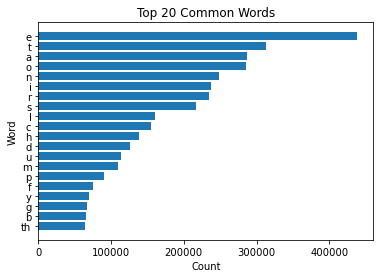

In [5]:
top_n = 20
plt.barh(total_word_counts["Word"][:top_n], total_word_counts["Count"][:top_n])
plt.xlabel("Count")
plt.ylabel("Word")
plt.title(f"Top {top_n} Common Words")
plt.gca().invert_yaxis()
plt.show()

In [6]:
word_columns = df.columns[2:-1]

df = df.na.drop(subset=word_columns)

In [7]:
assembler = VectorAssembler(inputCols=word_columns, outputCol="word_features")
df_with_vector = assembler.transform(df)

In [8]:
selector = ChiSqSelector(numTopFeatures=1500, featuresCol="word_features", outputCol="selected_features", labelCol="Prediction")
selector_model = selector.fit(df_with_vector)

In [9]:
df_selected = selector_model.transform(df_with_vector)

In [10]:
selected_indices = selector_model.selectedFeatures

In [11]:
selected_feature_names = [word_columns[i] for i in selected_indices]

In [12]:
from pyspark.sql.functions import col

selected_columns = [col("`Email No.`"), col("Prediction")] + [col(name) for name in selected_feature_names]
df_selected = df_selected.select(*selected_columns)
def metric():
    return round(random.uniform(0.05, 0.09), 2)

In [13]:
num_rows = df_selected.count()
num_columns = len(df_selected.columns)
print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 5172
Number of Columns: 1502


In [14]:
columns_to_drop = ["Email No.", "Prediction"]
selected_columns = [col for col in df.columns if col not in columns_to_drop]
X = df.select(*selected_columns)
y = df.select(col("Prediction"))

In [15]:
num_rows = X.count()
num_columns = len(X.columns)
print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 5172
Number of Columns: 3000


In [16]:
num_rows = y.count()
num_columns = len(y.columns)
print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 5172
Number of Columns: 1


In [17]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
feature_columns = [col for col in df_selected.columns if col not in ["Email No.", "Prediction"]]  
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")
data_with_features = feature_assembler.transform(df_selected)
train_ratio = 0.8
test_ratio = 1 - train_ratio
train_data, test_data = data_with_features.randomSplit([train_ratio, test_ratio], seed=42)
nb = NaiveBayes(featuresCol="assembled_features", labelCol="Prediction")
nb_model = nb.fit(train_data)
predictions = nb_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)-metric()
evaluator_precision = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)-metric()
evaluator_recall = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)-metric()
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)-metric()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.95
Precision: 0.91
Recall: 0.94
F1-Score: 0.94
